In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('./extracted_data.csv', index_col="Unnamed: 0")
df2 = pd.read_csv('./extracted_data2.csv', index_col="Unnamed: 0")

df = pd.concat([df,df2], axis=0, ignore_index=True)

df = df.drop(columns=[])
df.head()

,text_divergence,release_date_match,duration_match,img_similarity,label
0,11.057710,False,False,-0.916541,False
1,12.207992,False,False,-0.984052,False
2,13.456772,False,False,-0.287929,False
3,6.169476,False,False,0.930555,False
4,12.237637,False,False,-0.150630,False


In [3]:
df[df["label"]==True]

,text_divergence,release_date_match,duration_match,img_similarity,label
10,1.658873,True,True,0.999968,True
21,2.363202,True,True,0.999998,True
32,2.003297,True,True,0.997528,True
43,2.312251,True,True,1.000000,True
53,1.008220,True,True,0.999988,True
...,...,...,...,...,...
1935,1.348099,True,True,0.999757,True
1945,2.386639,True,True,0.995320,True
1956,4.294555,True,True,0.999743,True
1967,2.400904,True,True,0.999184,True


In [4]:
df.describe()

,text_divergence,img_similarity
count,1979.000000,1979.000000
mean,11.199775,0.529550
std,4.830976,0.551455
min,0.302347,-0.999996
25%,7.955838,0.129036
50%,12.423131,0.794118
75%,14.870063,0.992719
max,20.723266,1.000000


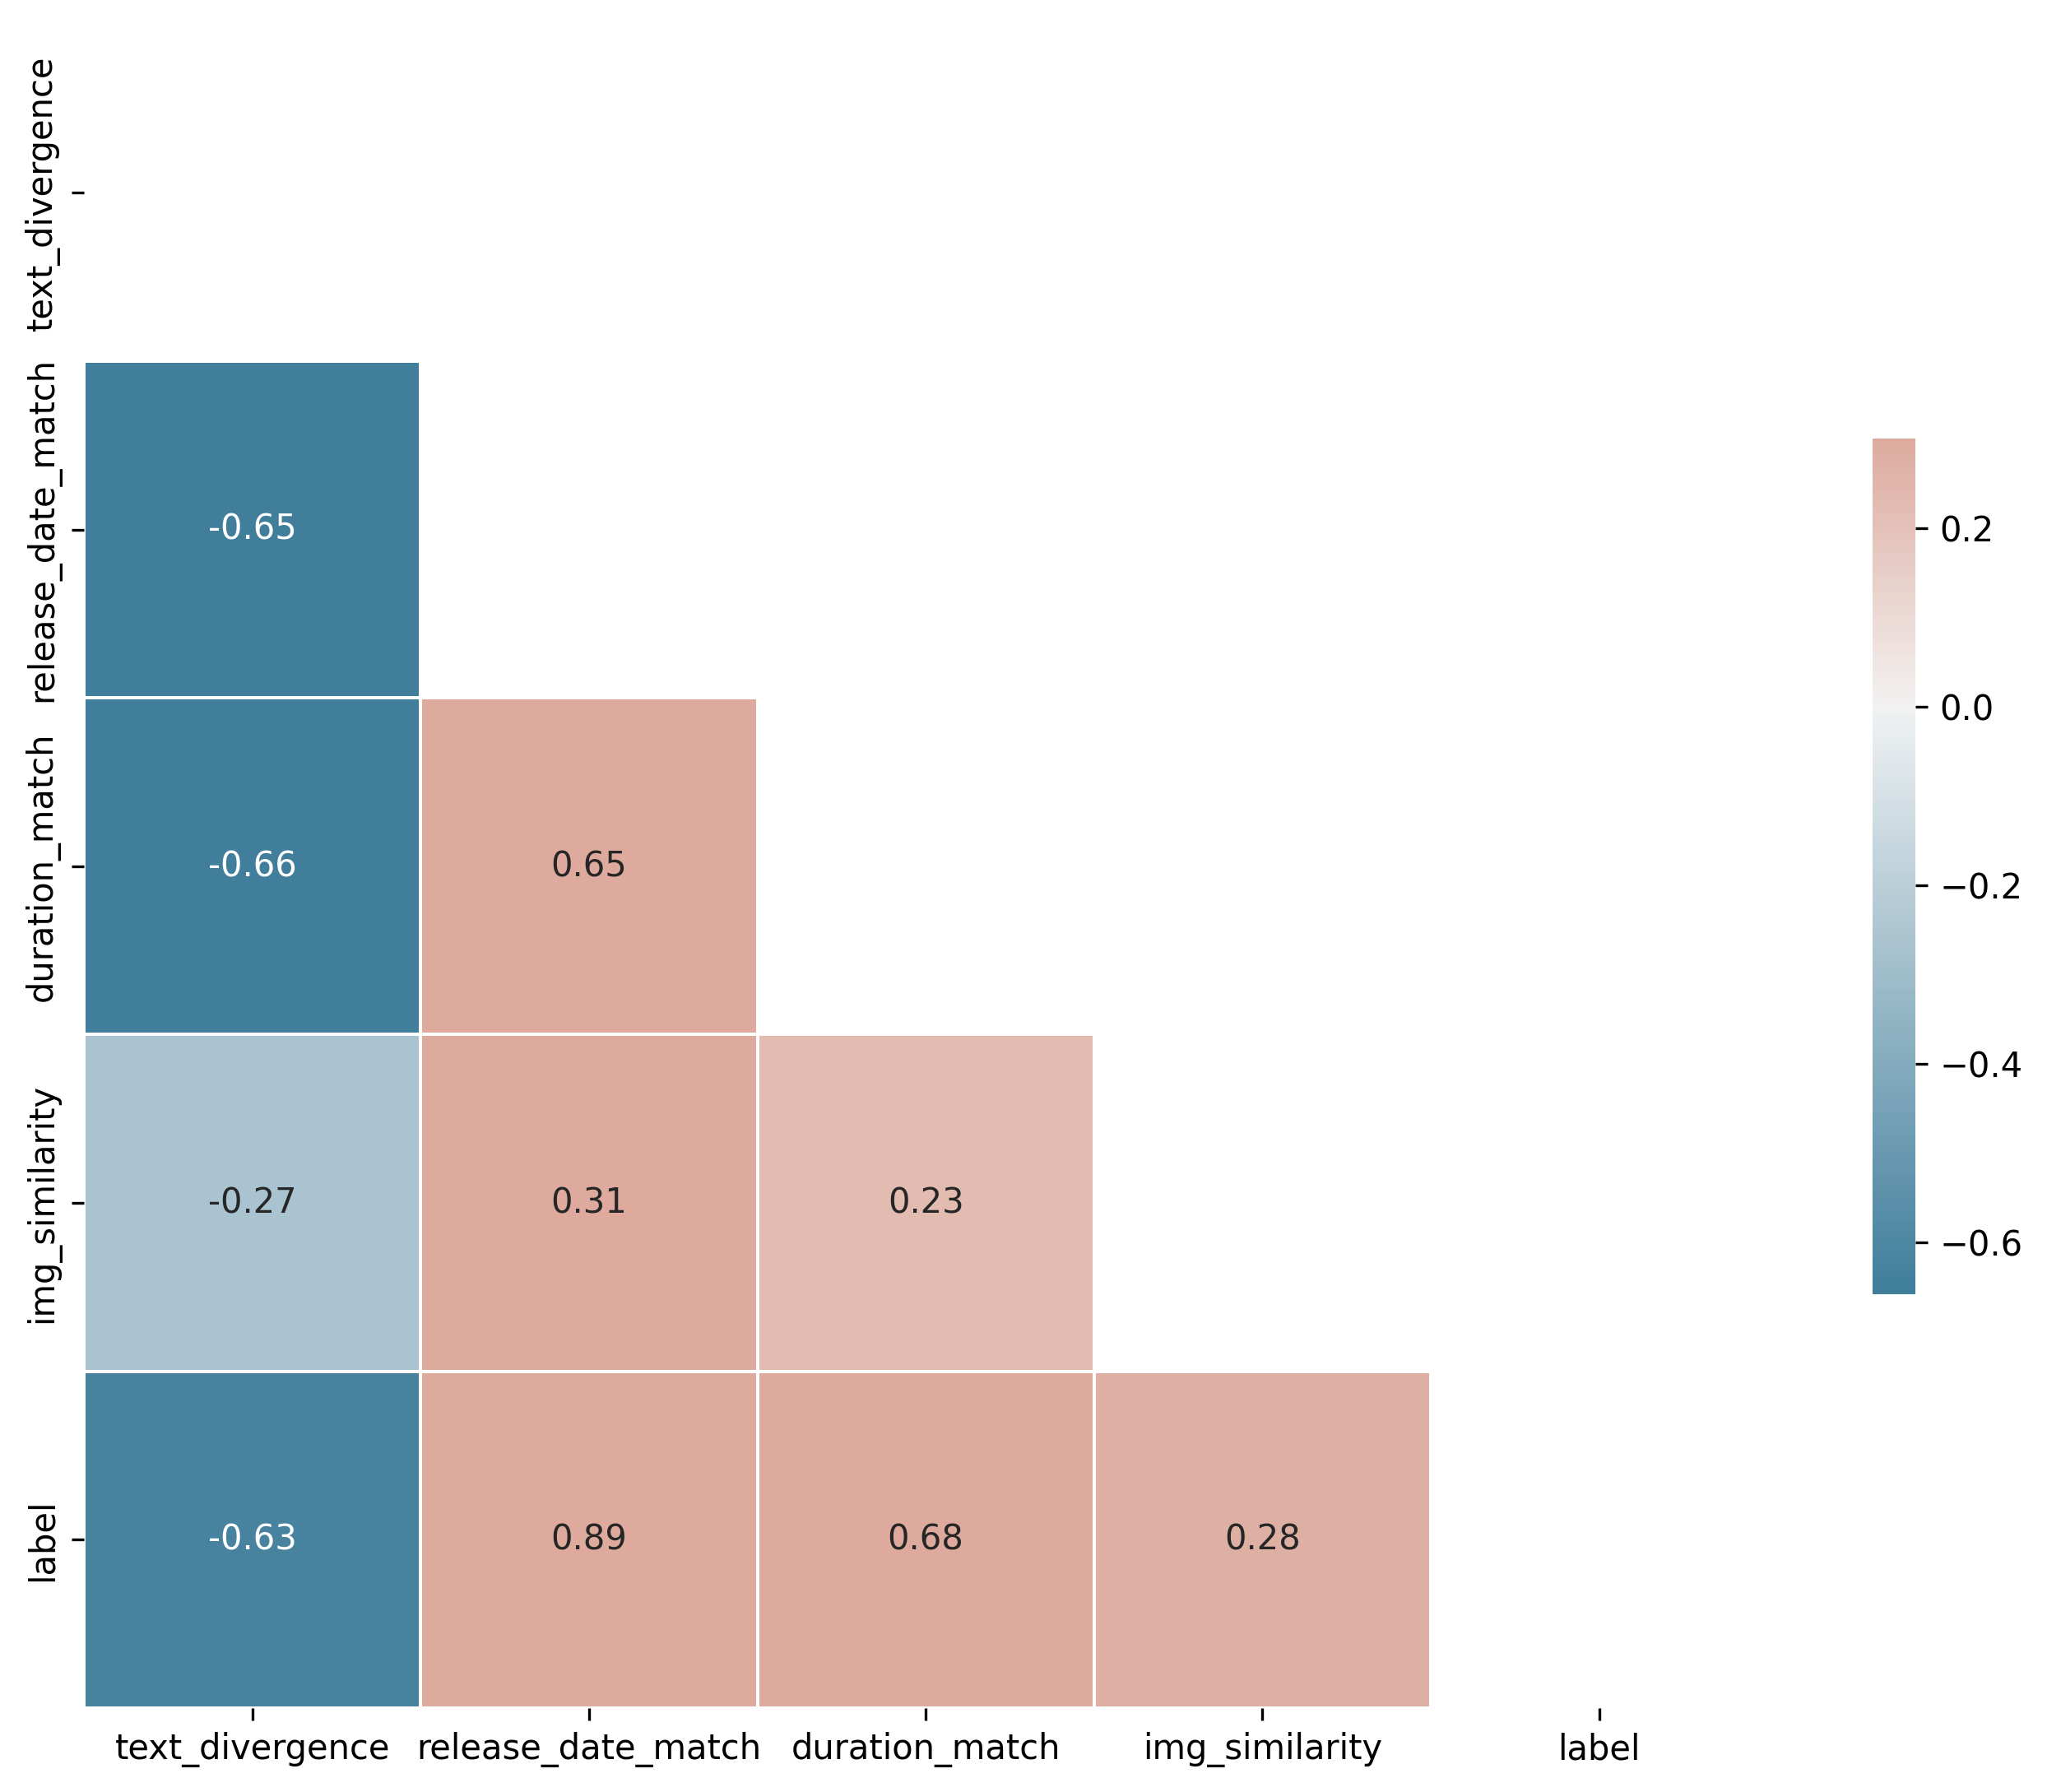

In [5]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9), dpi=300)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.savefig("correlations.png")

In [6]:
X = df.drop("label", axis=1)
X = X.to_numpy()

In [7]:
y = df.iloc[:, -1].astype(int)
y.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [8]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

oversampler = SMOTE(sampling_strategy='auto')
X, y = oversampler.fit_resample(X, y)
y = y.to_numpy()

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
#X_test = scaler.transform(X_test)

In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=20).fit_transform(X)

pca = PCA(n_components=2)
X = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.78593819, 0.15250732])

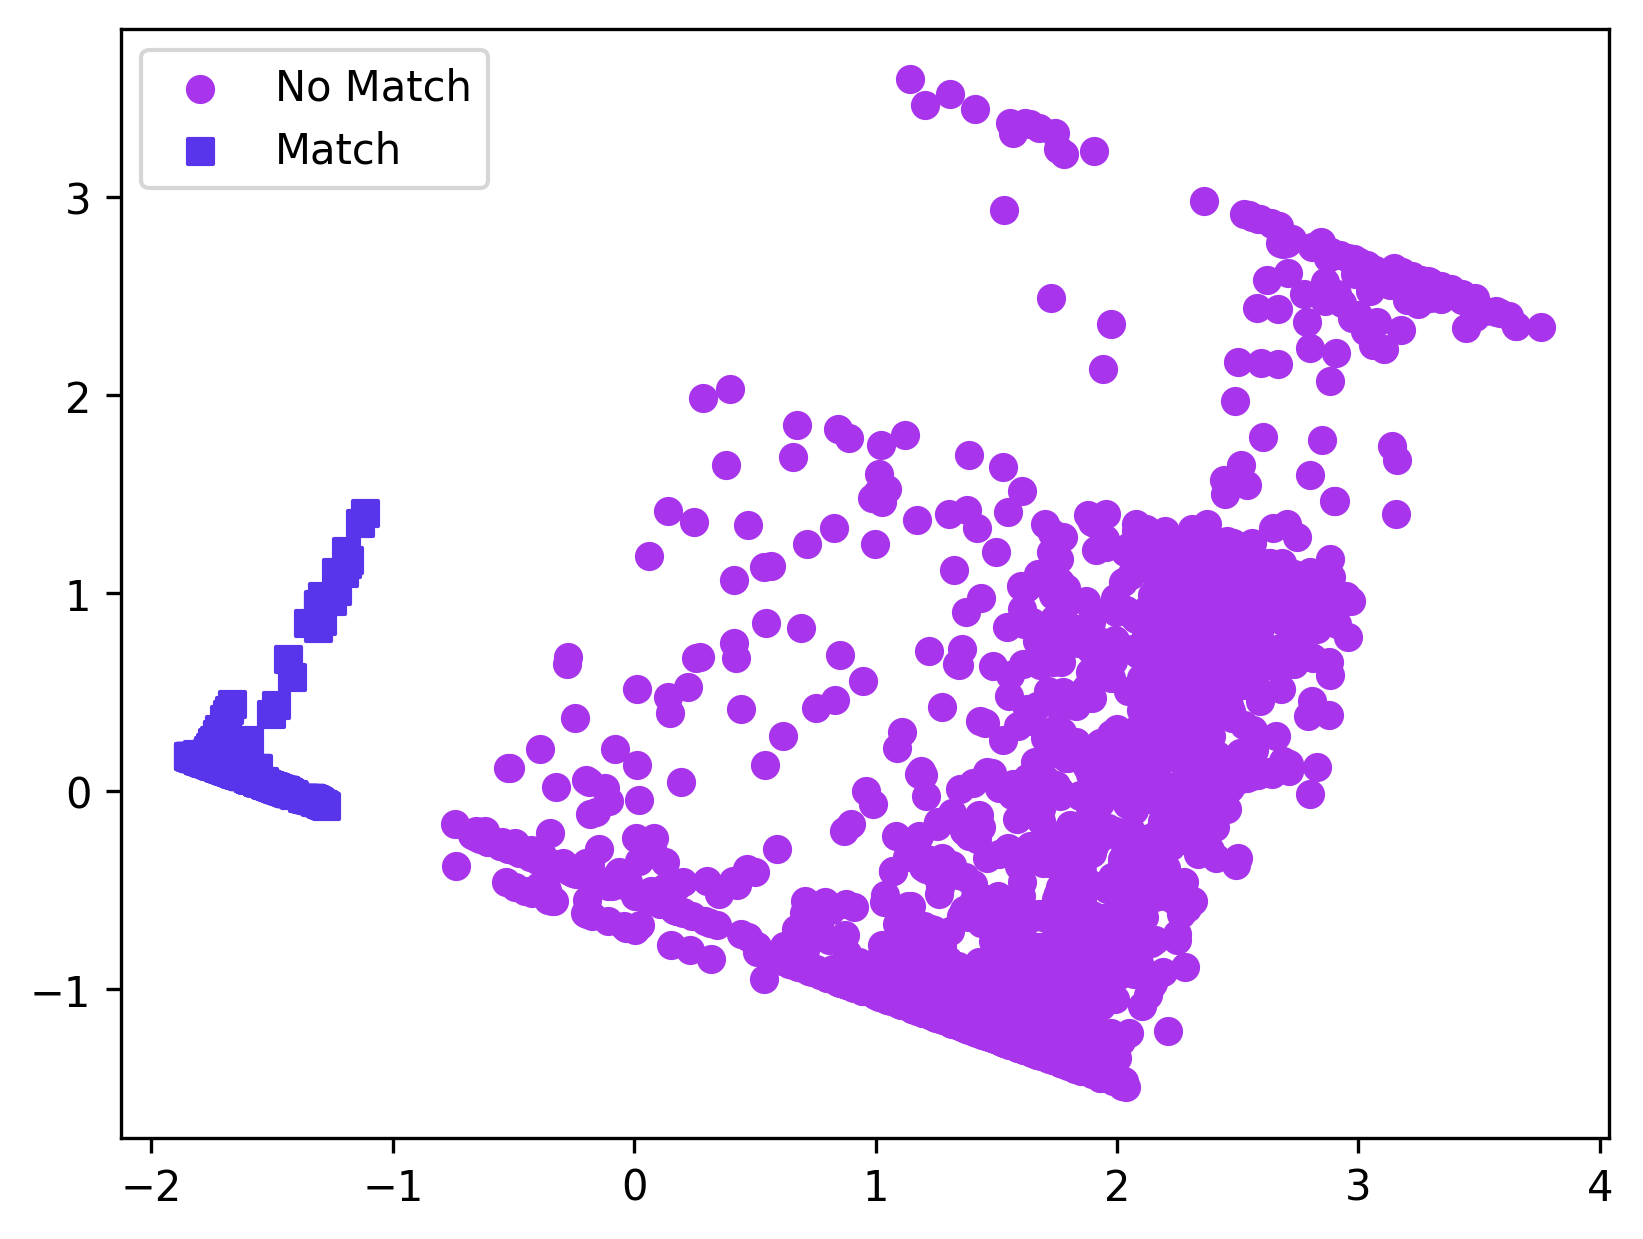

In [11]:
from matplotlib import pyplot as plt

fig, ax2 = plt.subplots(1, 1, dpi=300)
#ax1.scatter(X_embedded[:,0], X_embedded[:, 1], c=y)
#ax2.scatter(X[:,0], X[:, 1], c=y)
ax2.scatter(X[y == 0, 0], X[y == 0, 1], color='#a834eb', marker='o', label='No Match')
ax2.scatter(X[y == 1, 0], X[y == 1, 1], color='#5834eb',  marker='s', label='Match')
plt.legend(loc='upper left')
plt.savefig("pca.png")


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

In [13]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score, KFold

def print_scores(X, y, pred, model):
    print("SCORE:", model.score(X, y))
    print("Precision: ", average_precision_score(y, pred))
    print("Recall: ", recall_score(y, pred))

In [14]:
def kfold(model):
    kf = KFold(n_splits=5)
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        model.fit(X_train[train_index], y_train[train_index])
        pred = model.predict(X_train[test_index])

        print(f"RUN {i}")
        print_scores(X_train[test_index], y_train[test_index], pred, model)


In [15]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=0.1, random_state=42)
kfold(logreg)

RUN 0
SCORE: 0.9947368421052631
Precision:  0.9893617021276596
Recall:  1.0
RUN 1
SCORE: 0.9929701230228472
Precision:  0.9856115107913669
Recall:  1.0
RUN 2
SCORE: 0.9876977152899824
Precision:  0.9765100671140939
Recall:  1.0
RUN 3
SCORE: 0.9929701230228472
Precision:  0.9861111111111112
Recall:  1.0
RUN 4
SCORE: 0.9912126537785588
Precision:  0.9833333333333333
Recall:  1.0


In [18]:
from sklearn.svm import SVC

svm = SVC(kernel="linear", C=0.4, random_state=42)
kfold(svm)
pred = svm.predict(X_test)
print_scores(X_test, y_test, pred, svm)

RUN 0
SCORE: 0.9982456140350877
Precision:  0.9964285714285714
Recall:  1.0
RUN 1
SCORE: 0.9929701230228472
Precision:  0.9856115107913669
Recall:  1.0
RUN 2
SCORE: 0.9929701230228472
Precision:  0.9864406779661017
Recall:  1.0
RUN 3
SCORE: 0.9964850615114236
Precision:  0.993006993006993
Recall:  1.0
RUN 4
SCORE: 0.9964850615114236
Precision:  0.9932659932659933
Recall:  1.0
SCORE: 0.9957865168539326
Precision:  0.9916434540389972
Recall:  1.0


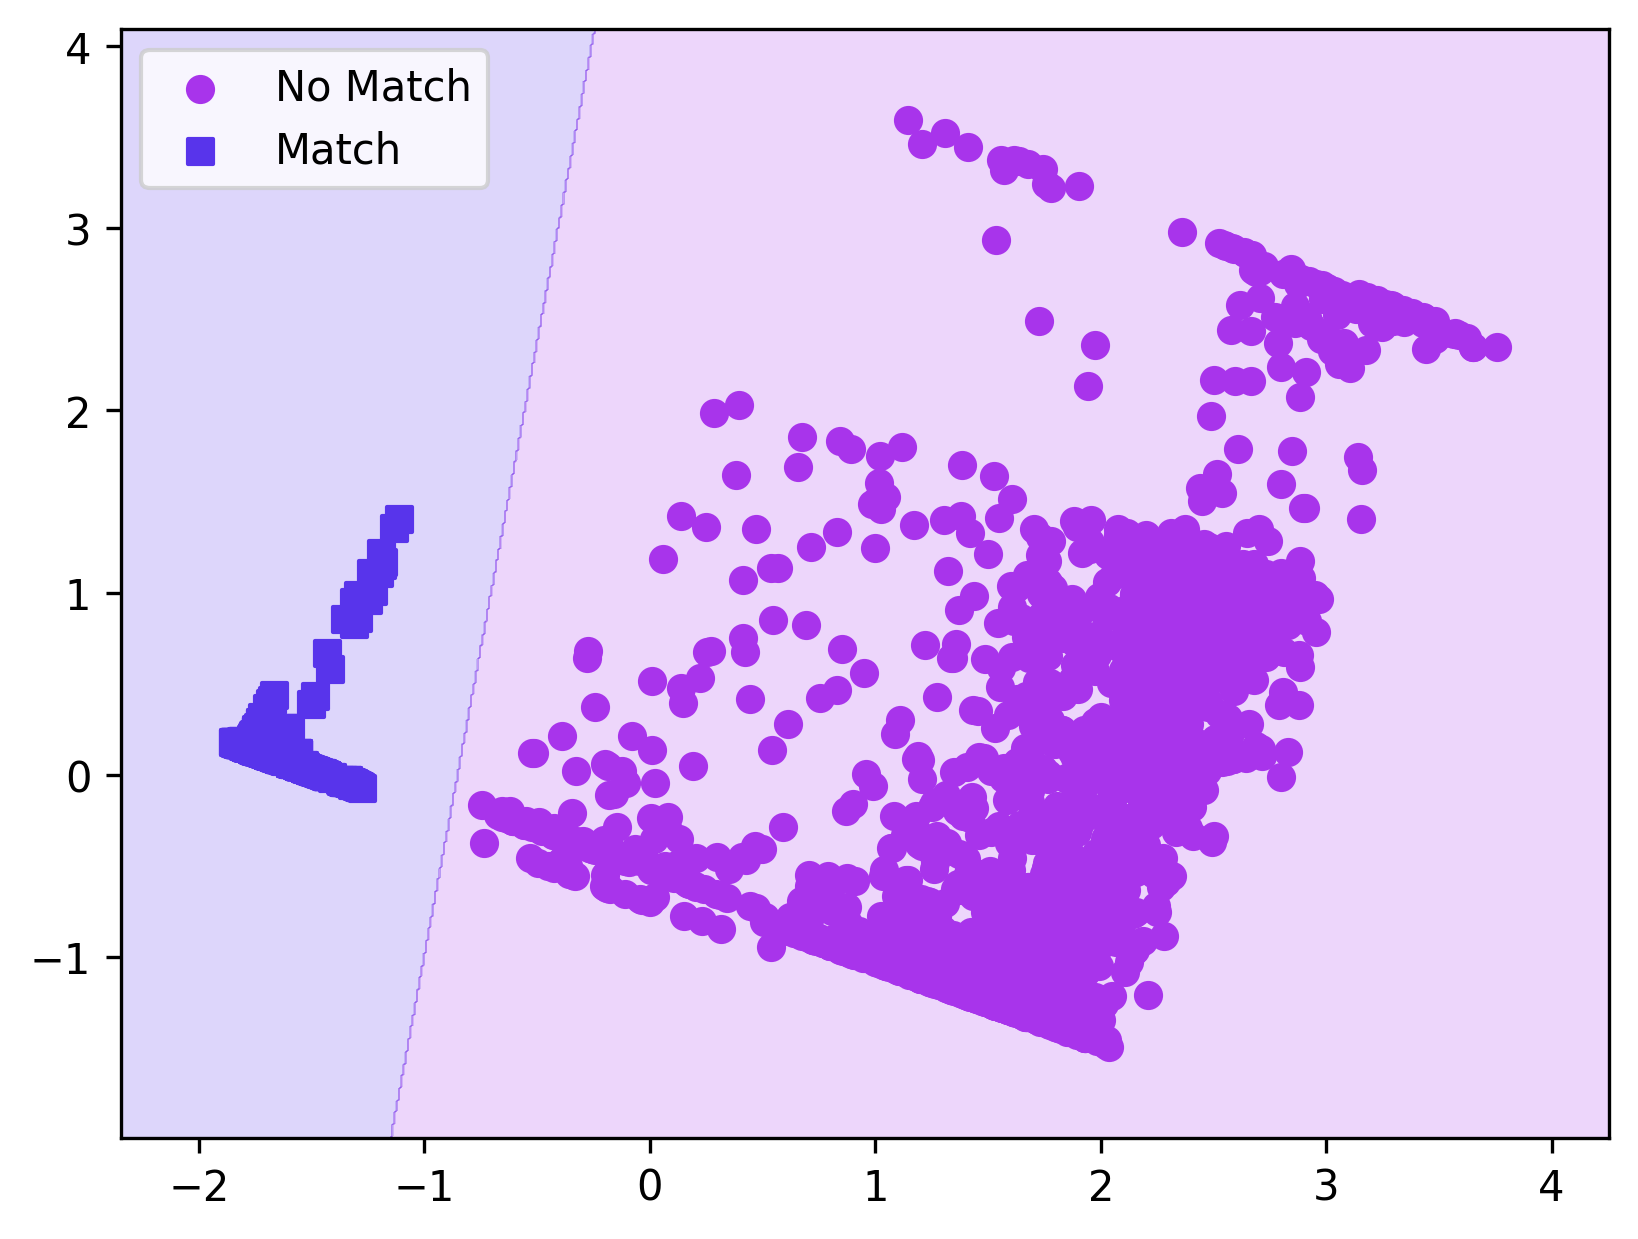

In [20]:
from matplotlib.colors import ListedColormap

def plot_boundaries(X, y, neuron, res=0.01):
    fig = plt.figure(dpi=300)
    x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, res), np.arange(x2_min, x2_max, res))
    all_coords = np.array([np.ravel(xx1), np.ravel(xx2)]).T
    
    pred = neuron.predict(all_coords).reshape(xx1.shape)

    plt.contourf(xx1,xx2, pred, alpha=0.2, colors=['#a834eb', '#5834eb', '#5834eb', '#a834eb'])
    
    plt.scatter(X[y == 0, 0], X[y == 0, 1], color='#a834eb', marker='o', label='No Match')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='#5834eb',  marker='s', label='Match')
    
    #plt.xlabel('Sepal Length')
    #plt.ylabel('Petal Length')
    plt.legend(loc='upper left')



plot_boundaries(X, y, svm)
plt.savefig("boundaries")